### Método Metropolis Checkerboard para el modelo de Ising

En el método "checkerboard", la red se divide en dos subredes intercaladas, similar a un tablero de ajedrez, donde una subred contiene todas las "casillas blancas" y la otra todas las "casillas negras". En cada paso de tiempo de la simulación, solo se actualizan los espines de una de las subredes, mientras que los de la otra se mantienen fijos. En el paso de tiempo siguiente, se invierten los roles: los espines que se mantuvieron fijos en el paso anterior se actualizan, y viceversa. Este procedimiento se repite alternando entre las dos subredes.

La ventaja de este método es que es paralelizable porque la aceptación de un cambio en una subred es independiente de la configuración de los espines en la misma subred.

Aunque el procedimiento no cumple balance detallado, se puede demostrar que sí satisface [balance global](https://www.sciencedirect.com/science/article/pii/S0378437113008091) por lo que permite llegar a la distribución de equilibrio.

En el código más abajo se presenta una implementación básica de este algoritmo usando CuPy para correr en GPU (en el Google colabs hay que solicitar un entorno de ejecución GPU para que funcione). Para intentar acelerar el código se usa una tabla para los vecinos de cada sitio y para las exponenciales de los factores de Boltzmann asociados al cambio de configuración (hay solo 5 valores posibles para el cambio de energía asociado a invertir un espín)

### Descripción del Código

1. **Importación de Módulos y Definición de Parámetros**
   - Se importan los módulos necesarios y se definen los parámetros de la simulación, como el tamaño de la red, el acoplamiento $J$, el número de pasos de Monte Carlo, etc.

2. **Inicialización de Arrays**
   - Se inicializan arrays para almacenar los valores de energía, magnetización, y temperaturas durante la simulación.

3. **Definición de Funciones Auxiliares**
   - Se definen funciones para calcular la energía total, la magnetización total, y para obtener los índices de los vecinos de un espín dado.

4. **Inicialización de Espines y Vecinos**
   - Se inicializan los arrays de espines blancos y negros y se construyen listas de vecinos para cada espín.

5. **Simulación de Monte Carlo**
   - Se lleva a cabo la simulación de Monte Carlo utilizando el algoritmo de Metropolis. En cada paso, se calculan los productos de los espines con sus vecinos y se decide si se invierten los espines basándose en los factores de Boltzmann.
   - Se calculan y almacenan los valores de energía y magnetización en cada paso. Cada paso corresponde a barrer todas las celdas blancas y todas las celdas negras.

6. **Cálculo de Cantidades Termodinámicas**
   - Después de la simulación, se calculan las cantidades termodinámicas promedio, excluyendo los pasos de equilibración. Se calcula la capacidad calorífica específica utilizando las fluctuaciones de la energía.

7. **Visualización de Resultados**
   - Finalmente, se transfieren los datos al CPU y se grafican la magnetización y la capacidad calorífica como función de la temperatura.


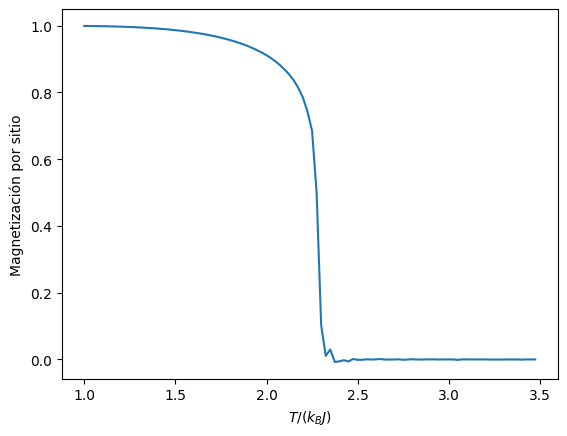

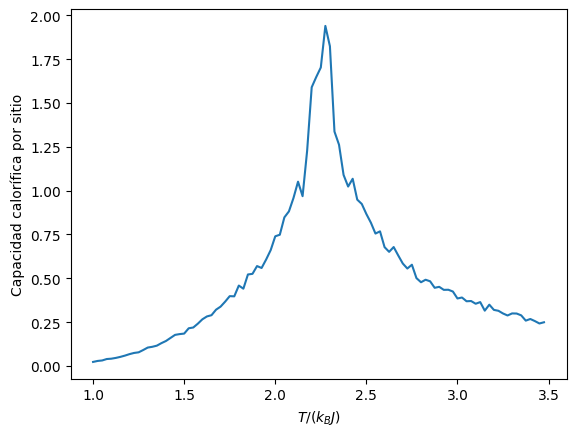

In [ ]:
import matplotlib.pyplot as plt
import cupy as cp

# Tamaño LxL: L tiene que ser divisible por 2
L = 512
# Acoplamiento
J = 1.0
# Número de pasos de Monte Carlo
Nt = 4000
# Pasos de equilibración
Neq = int(0.5*Nt)

#Número de temperaturas y rango
NTemp = 100
T_inicial = 1.0
T_final = 3.5
dt = (T_final-T_inicial)/NTemp

# Arreglos Auxiliares
''' Índices para los factores de Boltzmann de acuerdo al
valor P de la suma de los espines vecinos x el espín central
 tabla_de_cambios[P + 4]'''

tabla_de_cambios = cp.array([0, 0, 1, 0, 2, 0, 3, 0, 4], dtype=cp.int32)

energia_vals = cp.zeros((NTemp, Nt))
mag_vals= cp.zeros((NTemp, Nt))
temperaturas = cp.zeros(Nt)

def energia_total(espines_blancos, espines_negros, vecinos_blancos, vecinos_negros, J):
    # Alcanza con sumar sobre los blancos y sus vecinos
    energia = -J * cp.sum(espines_blancos * cp.sum(espines_negros[vecinos_blancos[:, :, 1]], axis=1))
    return energia

def magnetizacion_total(espines_blancos, espines_negros):
    magnetizacion = cp.sum(espines_blancos) +  cp.sum(espines_negros)
    return magnetizacion

# Valores iniciales de los espines
espines_blancos = cp.ones(L * L // 2, dtype=cp.int32)
espines_negros = cp.ones(L * L // 2, dtype=cp.int32)

#espines_blancos = cp.random.choice(cp.array([-1, 1], dtype=cp.int32), size=L * L // 2)
#espines_negros = cp.random.choice(cp.array([-1, 1], dtype=cp.int32), size=L * L // 2)

# Armamos un listado de vecinos
vecinos_blancos = []
vecinos_negros = []

# Índice unidimensional según las coordenadas i y j
def idx(i, j):
    return i * L + j

# indices de los 4 vecinos en la red completa usando condiciones periódicas de contorno
def mis_vecinos(i, j):
    arriba = idx((i - 1) % L, j)
    abajo = idx((i + 1) % L, j)
    izquierda = idx(i, (j - 1) % L)
    derecha = idx(i, (j + 1) % L)
    return [arriba, abajo, izquierda, derecha]

# Arma dos vectores con los espines de cada color y sus vecinos.
indice_blancos = 0
indice_negros = 0
for i in range(L):
    for j in range(L):
        vecinos = mis_vecinos(i, j)
        if (i + j) % 2 == 0:
            vecinos_blancos.append([(indice_blancos, n // 2) for n in vecinos])
            indice_blancos += 1
        else:
            vecinos_negros.append([(indice_negros, n // 2) for n in vecinos])
            indice_negros += 1

# matrices cupy
vecinos_blancos = cp.array(vecinos_blancos, dtype=cp.int32)
vecinos_negros = cp.array(vecinos_negros, dtype=cp.int32)

# Energía y magnetización iniciales
energia = energia_total(espines_blancos, espines_negros, vecinos_blancos, vecinos_negros, J)
magnetizacion = magnetizacion_total(espines_blancos, espines_negros)

#Posibles valores de cambio de productos: espín central por suma de vecinos
J_prods = cp.array([-8, -4, 0, 4, 8], dtype=cp.float32)


for k in range(0, NTemp):
    T = T_inicial + k * dt
    # Exponenciales para Metropolis
    exp_vals = cp.exp(-J * J_prods / T)

    for j in range(0,Nt):
        # Proponemos cambios en los espines "blancos" de manera secuencial.
        # Numeros uniforme [0,1] para decidir los cambios
        random_numbers = cp.random.rand(L * L // 2)
        # Todos los índices de los vecinos de los espines "blancos"
        indices_vecinos = vecinos_blancos[:, :, 1]

        # Productos de espin central y suma de espines vecinos
        productos = espines_blancos * cp.sum(espines_negros[indices_vecinos], axis=1)

        # indices para las exponenciales
        indices = tabla_de_cambios[productos + 4]
        # Para cuales aceptamos cambio?
        to_flip = random_numbers < exp_vals[indices]
        # Invertimos los cambios aceptados
        espines_blancos[to_flip] *= -1

        #Actualiza
        magnetizacion += 2 * cp.sum(espines_blancos[to_flip])
        energia += 2 * J * cp.sum(productos[to_flip])

        # Lo mismo para los espines en los cuadros Negros
        random_numbers = cp.random.rand(L * L // 2)
        indices_vecinos = vecinos_negros[:, :, 1]
        productos = espines_negros * cp.sum(espines_blancos[indices_vecinos], axis=1)
        indices = tabla_de_cambios[productos + 4]
        to_flip = random_numbers < exp_vals[indices]

        espines_negros[to_flip] *= -1
        magnetizacion += 2 * cp.sum(espines_negros[to_flip])
        energia += 2 * J * cp.sum(productos[to_flip])

        energia_vals[k,j] = energia
        mag_vals[k,j] = magnetizacion

# Cálculo de cantidades promedio excluyendo pasos de equilibración
energia_promedio = cp.mean(energia_vals[:, Neq:], axis=1)
energia2_promedio = cp.mean(energia_vals[:, Neq:]**2, axis=1)
magnet_promedio = cp.mean(mag_vals[:, Neq:], axis=1) /L**2

temperaturas = cp.linspace(T_inicial, T_inicial + (NTemp-1) * dt, NTemp)

cv = (energia2_promedio - energia_promedio**2) / (temperaturas**2)/L**2

# Transferimos datos al cpu
temperaturas_cpu = cp.asnumpy(temperaturas)
cv_cpu = cp.asnumpy(cv)
mag_cpu = cp.asnumpy(magnet_promedio)

# Plots
plt.plot(temperaturas_cpu, mag_cpu)
plt.xlabel('$T/(k_B J)$')
plt.ylabel('Magnetización por sitio')
plt.show()

plt.plot(temperaturas_cpu, cv_cpu)
plt.xlabel('$T/(k_B J)$')
plt.ylabel('Capacidad calorífica por sitio')
plt.show()




